References:
- How I built a Basic RAG for PDF QA in a few lines of python code (https://medium.com/@drjulija/how-i-built-a-basic-rag-for-pdf-qa-in-a-few-lines-of-python-code-9849c32e59f0)
- RAG + Langchain Python Project: Easy AI/Chat For Your Docs (https://youtu.be/tcqEUSNCn8I?si=orLmblgdnSGtLMus)
- Local Retrieval Augmented Generation (RAG) from Scratch (step by step tutorial) (https://youtu.be/qN_2fnOPY-M?si=j3e2hxymhZS86BLt)

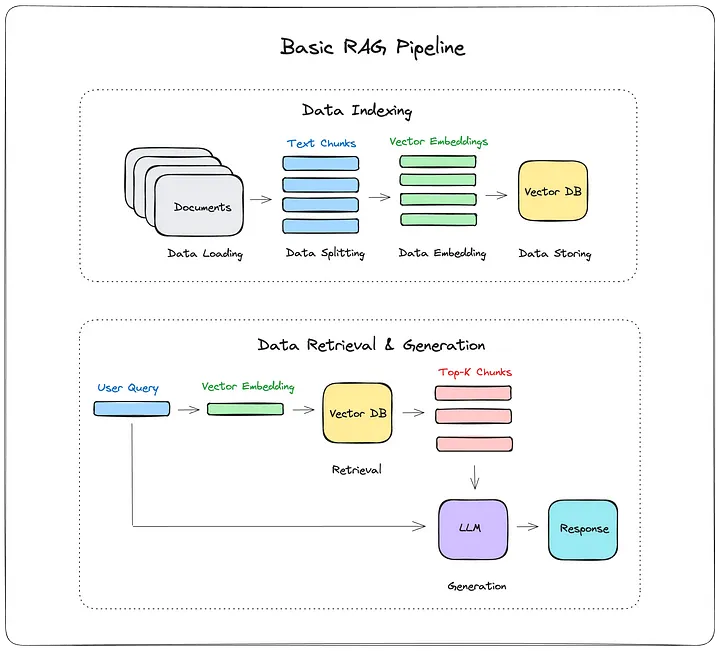

In [1]:
# Get the PDF file for this project
import os
import requests

file_path = "ai_modern_app_4.pdf"
if not os.path.exists(file_path):
    print(f"[INFO] The file {file_path} doesn't exist, downloading...")
    response = requests.get("https://people.engr.tamu.edu/guni/csce421/files/AI_Russell_Norvig.pdf")
    if response.status_code == 200:
        with open(file_path, "wb") as file:
            file.write(response.content)
        print(f"[INFO] The file has been downloaded and saved as {file_path}")
    else:
        print(f"[INFO] Failed to download the file {file_path}. [{response.status_code}]")
else:
    print(f"[INFO] The file {file_path} exists.")

[INFO] The file ai_modern_app_4.pdf exists.


In [2]:
# Get the PDF contents into a dict variable
import fitz

def format_inline(text: str) -> str:
    cleaned_text = text.replace("\n", " ").strip()
    return cleaned_text

def read_pdf(file_path: str, page_number_start: int) -> list[dict]:
    doc = fitz.open(file_path)
    pages = []
    for page_number, page_text in enumerate(doc):
        text = page_text.get_text()
        cleaned_text = format_inline(text)
        pages.append({"pdf_page_number" : page_number + 1,
                    "page_number" : page_number - page_number_start + 2,
                    "page_content" : cleaned_text})
    return pages

pages = read_pdf(file_path, 20)

In [3]:
# In this case, we don't need unnecessary pages
pages = pages[19:]

In [4]:
# Extract chunks from the PDF contents and convert each chunk into an item with its metadata
from langchain.text_splitter import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(chunk_size = 512, chunk_overlap = 32)

docs = []

for page in pages:
    page_chunks = text_splitter.split_text(page["page_content"])
    for chunk_index, chunk_text in enumerate(page_chunks):
        metadata = {
            "pdf_page_number": page["pdf_page_number"],
            "page_number" : page["page_number"],
            "file_name" : file_path
        }
        docs.append({"metadata" : metadata, "chunk_text" : chunk_text})

In [5]:
# In this case, I need only 128 chunks (because my computer is really poor, sorry 😔)
docs = docs[:128]

In [6]:
%%time

# Encoding the chunks into chunk vectors
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer(model_name_or_path = "all-mpnet-base-v2",
                                      device = "cpu")

n = len(docs)
for i, doc in enumerate(docs):
    print(i + 1, "/", n)
    doc["chunk_vector"] = embedding_model.encode(doc["chunk_text"])

C:\Users\Jedsada\anaconda3\envs\pdf_qa\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
C:\Users\Jedsada\anaconda3\envs\pdf_qa\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


1 / 128
2 / 128
3 / 128
4 / 128
5 / 128
6 / 128
7 / 128
8 / 128
9 / 128
10 / 128
11 / 128
12 / 128
13 / 128
14 / 128
15 / 128
16 / 128
17 / 128
18 / 128
19 / 128
20 / 128
21 / 128
22 / 128
23 / 128
24 / 128
25 / 128
26 / 128
27 / 128
28 / 128
29 / 128
30 / 128
31 / 128
32 / 128
33 / 128
34 / 128
35 / 128
36 / 128
37 / 128
38 / 128
39 / 128
40 / 128
41 / 128
42 / 128
43 / 128
44 / 128
45 / 128
46 / 128
47 / 128
48 / 128
49 / 128
50 / 128
51 / 128
52 / 128
53 / 128
54 / 128
55 / 128
56 / 128
57 / 128
58 / 128
59 / 128
60 / 128
61 / 128
62 / 128
63 / 128
64 / 128
65 / 128
66 / 128
67 / 128
68 / 128
69 / 128
70 / 128
71 / 128
72 / 128
73 / 128
74 / 128
75 / 128
76 / 128
77 / 128
78 / 128
79 / 128
80 / 128
81 / 128
82 / 128
83 / 128
84 / 128
85 / 128
86 / 128
87 / 128
88 / 128
89 / 128
90 / 128
91 / 128
92 / 128
93 / 128
94 / 128
95 / 128
96 / 128
97 / 128
98 / 128
99 / 128
100 / 128
101 / 128
102 / 128
103 / 128
104 / 128
105 / 128
106 / 128
107 / 128
108 / 128
109 / 128
110 / 128
111 / 12

In [7]:
# Store the chunk vectors into ChromaDB (with their metadata)
import chromadb

collection_name = "abook_db"

client = chromadb.Client()

collection = None
try:
    client.delete_collection(collection_name)
except:
    collection = client.create_collection(name = collection_name)

collection.add(
    ids = [str(i) for i in range(len(docs))],
    embeddings = [doc["chunk_vector"].tolist() for doc in docs],
    metadatas = [doc["metadata"] for doc in docs],
    documents = [doc["chunk_text"] for doc in docs]
)

In [8]:
# Get Gemini API and model
from dotenv import load_dotenv
import os
import google.generativeai as genai

load_dotenv()

SECRET_KEY = os.environ.get('SECRET_KEY')

genai.configure(api_key = SECRET_KEY)
model = genai.GenerativeModel("gemini-1.5-pro")

In [19]:
# Querying
query = "What is AI?"
results = collection.query(embedding_model.encode(query).tolist(), n_results = 3)

# Get context from results
context = "\n\n".join([chunk for chunk in results["documents"][0]])

# Generation
prompt = f"""
Answer the question based only on the following context:

{context}

---

Answer the question based on the above context (Do not metion about the above context text): {query}
"""

response = model.generate_content(prompt)

In [20]:
# Response
response.text

'AI, or artificial intelligence, is the field of study that aims to build intelligent entities. It focuses not only on understanding but also on replicating human-like intelligence in machines, enabling them to learn, reason, and make decisions. \n'